In [1]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation, Conv2D, Flatten, MaxPooling2D, Dense, PReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')  
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import tensorflow as tf
import os

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")



2025-09-30 21:57:13.981111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 21:57:15.352162: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 21:57:15.635362: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU memory growth enabled for 1 GPU(s)


##IMPORTANT!!
NEED TO CHANGE INPUT/OUTPUT path for CESM1/CESM2

In [2]:
# [saved ML training data] /ocean/projects/ees250004p/ezhu3/data/BCC-CSM2-MR/ML-data/input.IPSL-CM6A-LR.piControl.ANN.nc
# [saved ML test data] /ocean/projects/ees250004p/ezhu3/data/BCC-CSM2-MR/ML-data/test.IPSL-CM6A-LR.4xCO2.ANN.nc
# [saved ML output data] /ocean/projects/ees250004p/ezhu3/data/BCC-CSM2-MR/ML-data/output.IPSL-CM6A-LR.TOA.ANN.nc


# Load the input variable -- global Surface temperature
ds = xr.open_dataset("/ocean/projects/ees250004p/ezhu3/data/BCC-CSM2-MR/ML-data/input.IPSL-CM6A-LR.piControl.ANN.nc")

print(ds)
# Access the variables (matching PI's naming)
TS = ds["TS_anom"]  # Surface temperature anomalies (spatial) - units = 'K'
lat = ds["TS_anom"].lat  # latitude
lon = ds["TS_anom"].lon  # longitude  
time = ds["TS_anom"].time

# Define the directory where the output variables are stored
data_dir = "/ocean/projects/ees250004p/ezhu3/data/BCC-CSM2-MR/ML-data"

# Define the filenames and corresponding variable names
files = {
    "TOA_anom": "output.IPSL-CM6A-LR.TOA.ANN.nc"
}

datasets = {}
# Load variables
for var, filename in files.items():
    file_path = os.path.join(data_dir, filename)
    ds_load = xr.open_dataset(file_path)
    datasets[var] = ds_load["TOA_anom"]  # Extract the TOA_anom variable

# Now the variables can be accessed as datasets["TOA_anom"]
# path for storing the trained neural networks
data_dir = '/ocean/projects/ees250004p/ezhu3/BCC-CSM2-MR/trained_model'

<xarray.Dataset>
Dimensions:   (time: 600, lon: 320, lat: 160)
Coordinates:
  * time      (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float32 ...
    TOA       (time) float32 ...
    TOA_anom  (time) float32 ...
Attributes:
    script:       verify_cmip6.py
    author:       Modified for ML training
    description:  piControl data in PI's format: TS_anom(spatial) + TOA_anom(...


In [3]:



            
# Neural network architecture:
# Example: [64, 64, 64] means three hidden layers, each containing 64 neurons.
kernels = [32, 32]
kernel_acts =  ["gelu", "gelu"]
kernel_size = 3
stride = 1
rng_seed = 42
hiddens = [16, 8]
activation_function_dense = ["PRelu", "PRelu"]
pool_size = 2

# Loss function for regression tasks:
# Full list of regression losses: https://keras.io/api/losses/
loss_function = 'mse'


reg_strength = 0         # L2 regularization strength; 1e-1~1e-5
dropout_rate = 0.25         # Dropout rate (0.0 to disable dropout)


# low-pass filter time scale; 0 means no low-pass filter
LPF_year = 0


#### normalization
remove_mean = 0
divide_std = 1


#### usually we do not change the parameters below 

# Training configuration
epoch_max = 25000            # Maximum number of training epochs
batch_size = 32            # Batch size used during training
learning_rate = 0.000005       # Default learning rate for Adam optimizer 0.001

    



num_folds = 5 # Number of fold during cross-validation
NNrepeats = 1 # Repeat the training for NNrepeats times




In [4]:


# input_raw = TS.values.reshape(TS.shape[0],TS.shape[1]*TS.shape[2])
# For CNN, we don't need to flatten the data
input_raw = TS.values



# Define the variable names as a comma-separated string
# names_strALL = "CRE,FLNT,FSNT,LCC,LWCF,SWCF,TCC,TOA"
# If we only want to reconstruct TOA
names_strALL = "TOA_anom"
names_str = "TOA_anom"

output_raw = datasets[names_str].values.reshape(-1,1)

In [5]:

def create_NN_name():

    NN_name = 'CNN'
        
    activation_function_str = '_'+kernel_acts[0]+ '+'+activation_function_dense[0] 
    loss_function_str = '_'+str(loss_function)+'loss' if loss_function!='mse' else ''
    
    if remove_mean + divide_std == 0:
        scaler_str = 'NoScaler_'
    elif remove_mean + divide_std == 2:
        scaler_str = 'StandardScaler_'
    elif remove_mean:
        scaler_str = 'RemoveMean_'
    elif divide_std:
        scaler_str = 'DivideSTD_'
    LPF_str = f'_LPF{int(LPF_year)}Year' if LPF_year else ''
    NN_structure_str = 'x'.join(map(str, kernels)) 
    reg_str = f'Reg{reg_strength}' + (f'Drop{dropout_rate}' if dropout_rate != 0 else '')
    batch_size_str =  f'BS{batch_size}_' if batch_size !=600 else ''
    return f"{NN_name}_{scaler_str}Neur{NN_structure_str}_{batch_size_str}{num_folds}foldCV_{reg_str}{loss_function_str}{activation_function_str}{LPF_str}"
NN_name = create_NN_name()

    
def construct_output_directory(data_dir, NN_name):
    output_dir = os.path.join(data_dir, 'NeuralNet', NN_name, names_str)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

output_dir = construct_output_directory(data_dir, NN_name)
        


In [6]:
logger_name = 'logfile.log'  
# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
file_handler = logging.FileHandler(os.path.join(output_dir, logger_name))
console_handler = logging.StreamHandler()

# Set level and format for handlers
file_handler.setLevel(logging.INFO)
console_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Test the setup
logger.info("logfile")

 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    logger.info("Using GPU for training.")
    logger.info(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    logger.info("Using CPU for training.") 

logger.info(os.getenv('TF_GPU_ALLOCATOR'))
    
logger.info(f"Output path: {'created successfully' if os.path.exists(output_dir) else 'already exists'}")
logger.info(f"The output path is {output_dir}")

2025-09-30 21:57:23,514 - logfile
2025-09-30 21:57:23.519704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 21:57:24,480 - Using GPU for training.
2025-09-30 21:57:24.473982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2025-09-30 21:57:24,481 - 1 Physical GPUs, 1 Logical GPUs
2025-09-30 21:57:24,481 - None
2025-09-30 21:57:24,482 - Output path: created successfully
2025-09-30 21:57:24,482 - The output path is /ocean/projects/ees250004p/ezhu3/BCC-CSM2-MR/trained_model/NeuralNet/CNN_DivideSTD

In [7]:

logger.info('------------------------------------------------------------------------')
logger.info('------------------------------------------------------------------------')
logger.info(f'Applying {LPF_year}-year low pass filter ...')
logger.info('------------------------------------------------------------------------')
logger.info('------------------------------------------------------------------------')

from scipy.signal import butter, sosfilt

def apply_low_pass_filter(data, cutoff_freq, order=5, sampling_rate=1, padding_length=None):
    """Applies a Butterworth low-pass filter to the given data."""
    sos = butter(order, cutoff_freq, btype='low', output='sos', analog=False, fs=sampling_rate)
    
    # Apply Boundary Padding to the data before filtering
    padded_data = np.pad(data, [(padding_length, padding_length), (0, 0)], mode='reflect')
    
    # Apply the filter across each column without explicit looping
    filtered_data = sosfilt(sos, padded_data, axis=0)
    
    # Remove padding
    return filtered_data[padding_length:-padding_length]

if LPF_year:
    # Calculate the sampling rate (monthly data)
    sampling_rate = 1  # Data is sampled monthly    
    cutoff_freq = 1 / LPF_year
    order = 5
    padding_length =  3* LPF_year

if LPF_year:
    input = apply_low_pass_filter(input_raw, cutoff_freq, order, sampling_rate, padding_length)     
    output= apply_low_pass_filter(output_raw, cutoff_freq, order, sampling_rate, padding_length)     
    
    plt.figure(figsize=(30, 6))  
    plt.plot(time, output_raw, label="Original", color="C0", linewidth=2)  # Use color and linewidth
    plt.plot(time, output, label="Low-pass filtered", color="C1", linestyle="-", linewidth=1.5)  # Dashed line for prediction
    plt.xlabel("Time (year)", fontsize=14)
    plt.ylabel(names_str, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12, loc="best")
    plt.savefig(os.path.join(output_dir, names_str+"_LPF.png"), dpi=300, bbox_inches="tight")
    plt.show()
else:
    input  =  input_raw
    output = output_raw

2025-09-30 21:57:24,491 - ------------------------------------------------------------------------
2025-09-30 21:57:24,491 - ------------------------------------------------------------------------
2025-09-30 21:57:24,492 - Applying 0-year low pass filter ...
2025-09-30 21:57:24,492 - ------------------------------------------------------------------------
2025-09-30 21:57:24,493 - ------------------------------------------------------------------------


In [8]:
#######################################################################
#                       define the neural network                     #
#######################################################################

log_path =os.path.join(output_dir, 'training_logs.txt')
os.makedirs(os.path.dirname(log_path), exist_ok=True)
class PrintTrainingOnTextEvery10EpochsCallback(Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Log every 10 epochs
            with open(self.log_path, "a") as log_file:
                log_file.write(
                    f"Epoch: {epoch:>3} | "
                    f"Loss: {logs.get('loss', 0):.2e} | "
#                        f"Accuracy: {logs.get('accuracy', 0):.2e} | "
                    f"Validation loss: {logs.get('val_loss', 0):.2e} |\n "
#                        f"Validation accuracy: {logs.get('val_accuracy', 0):.2e}\n"
                )
                print(
                    f"Epoch {epoch:>3} - "
                    f"Loss: {logs.get('loss', 0):.2e}, "
#                        f"Accuracy: {logs.get('accuracy', 0):.2e}, "
                    f"Validation loss: {logs.get('val_loss', 0):.2e}, "
#                        f"Validation accuracy: {logs.get('val_accuracy', 0):.2e}"
                )

my_callbacks = [
    PrintTrainingOnTextEvery10EpochsCallback(log_path=log_path),
]   

def train_model(X_train, y_train, X_test, y_test, y_mean, y_std):
    inputs = tf.keras.Input(shape=(X_train.shape[1:]),)
    layers = inputs

    # Convolutional Layers
    for i, kernel_filters in enumerate(kernels): # Assuming kernels is a list of filter numbers
        layers = Conv2D(
            kernel_filters,
            (kernel_size, kernel_size), # Assuming kernel_size is defined
            strides=(stride, stride),     # Assuming stride is defined
            use_bias=True,
            padding="same",
            # NO 'activation' argument here if PReLU or another layer follows
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        )(layers)

        # Apply PReLU
        # Assuming kernel_acts[i] could be 'prelu', 'gelu', 'relu', etc.
        if kernel_acts[i].lower() == 'prelu':
            layers = PReLU(shared_axes=[1, 2],
                           alpha_initializer=tf.keras.initializers.Constant(0.25) # Common starting point
                          )(layers) # shared_axes for Conv2D with channels_last
        elif kernel_acts[i].lower() == 'gelu':
            layers = tf.keras.layers.Activation('gelu')(layers) # Using Activation layer for GeLU
        elif kernel_acts[i]: # For 'relu', 'elu', etc.
            layers = tf.keras.layers.Activation(kernel_acts[i])(layers)

        layers = MaxPooling2D((pool_size, pool_size))(layers) # Assuming pool_size is defined
    
    layers = Flatten()(layers)

    # Dense Layers
    for i, hidden_units in enumerate(hiddens): # Assuming hiddens is a list of unit numbers
        layers = Dense(
            hidden_units,
            use_bias=True,
            # NO 'activation' argument here
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        )(layers)

        # Apply PReLU (or other chosen activation)
        # Assuming activation_function_dense[i] could be 'prelu', 'gelu', 'elu', etc.
        if activation_function_dense[i].lower() == 'prelu':
            layers = PReLU(alpha_initializer=tf.keras.initializers.Constant(0.25))(layers) # No shared_axes for Dense
        elif activation_function_dense[i].lower() == 'gelu':
            layers = tf.keras.layers.Activation('gelu')(layers)
        elif activation_function_dense[i]: # For 'elu', 'relu', etc.
            layers = tf.keras.layers.Activation(activation_function_dense[i])(layers)
        # If activation_function_dense[i] is None or an empty string, no explicit activation layer.

    output_layer = Dense(
        y_train.shape[-1], # Assuming y_train is (samples, features_out) or (samples,)
        activation="linear",
        use_bias=True,
        bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
    )(layers)
    
    model = Model(inputs, output_layer)

    if fold_no + ens_no == 2:
        model.summary()

    model.compile(loss=loss_function, optimizer=Adam(learning_rate=learning_rate)) # Assuming these are defined

    early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1) # restore_best_weights=1 is True

    # Make sure my_callbacks is defined in this scope or passed as an argument
    history = model.fit(X_train, y_train, epochs=epoch_max, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[early_stopping] + my_callbacks, verbose=0) # Added '+' for list concatenation

    skill = model.evaluate(X_test, y_test, verbose=0)
    pred = (model.predict(X_test) * y_std) + y_mean # Make sure y_std and y_mean are defined

    R2_val = []
    truth = (y_test * y_std) + y_mean
    for latind in range(truth.shape[1] if truth.ndim > 1 else 1): # Handle if y_test is 1D output
        y_lat = truth[:, latind] if truth.ndim > 1 else truth
        y_pred_lat = pred[:, latind] if pred.ndim > 1 else pred
        R2_val.append(r2_score(y_lat, y_pred_lat))
    
    model.save(os.path.join(output_dir,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
    
    return skill, history, pred, R2_val
        



In [9]:
#######################################################################
#                             Train loop                              #
#######################################################################
X = input
y = output

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)

if remove_mean ==0:
    X_mean = 0
    y_mean = 0

    
    
if divide_std ==0:
    X_std = 1
    y_std = 1
else:
    X_std = X_std[:,:, tf.newaxis]
    
    
    
sio.savemat(os.path.join(output_dir,'Normalization.mat'), 
            {'X_mean': X_mean, 'X_std': X_std,'y_mean':y_mean,'y_std':y_std})

# if not os.path.exists(os.path.join(output_dir, 'inputs_info.mat')):

        
trained_models = []
y_pred_reconstructed_allfolds = []


# Train the neural network multiple times using k-fold cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)
fold_no = 1
for trainind, testind in kfold.split(X, y):   
    # break
    X_train = X[trainind,:,:, tf.newaxis]
    y_train = y[trainind,:]
    X_test = X[testind,:, :,tf.newaxis]
    y_test = y[testind,:]
 
    # Normalize the input and out data based on the information from the entire PI control run
    
    
    X_train = (X_train - X_mean)/X_std
    X_test = (X_test - X_mean)/X_std
    
    y_train = (y_train - y_mean)/y_std
    y_test = (y_test - y_mean)/y_std
    
    
    
    # Generate a print
    logger.info('------------------------------------------------------------------------')
    # We use ensemble training for each fold of the cross-validation
    for ens_no  in np.arange(1,NNrepeats+1):
        logger.info(f'Training for fold {fold_no} ensemble {ens_no}...')
        skill, history, pred, R2_val = train_model(X_train, y_train, X_test, y_test,y_mean,y_std)
        trained_models.append((skill, skill, history.history, pred, R2_val))

        
    # Increase fold number
    fold_no = fold_no + 1
    tf.keras.backend.clear_session()
    gc.collect()

        
        
logger.info('------------------------------------------------------------------------')
logger.info(f'Training with {num_folds}-fold cross-validation finished!') 
logger.info('------------------------------------------------------------------------')

2025-09-30 21:57:24,767 - ------------------------------------------------------------------------
2025-09-30 21:57:24,768 - Training for fold 1 ensemble 1...


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 320, 32)      320       
                                                                 
 activation (Activation)     (None, 160, 320, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 160, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 160, 32)       9248      
                                                                 
 activation_1 (Activation)   (None, 80, 160, 32)       0         
                                                             

2025-09-30 21:57:25.116018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2025-09-30 21:57:25.138074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-09-30 21:57:26.357009: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


Epoch   0 - Loss: 1.03e+00, Validation loss: 8.77e-01, 
Epoch  10 - Loss: 9.84e-01, Validation loss: 8.55e-01, 
Epoch  20 - Loss: 9.33e-01, Validation loss: 8.18e-01, 
Epoch  30 - Loss: 8.69e-01, Validation loss: 7.70e-01, 
Epoch  40 - Loss: 7.91e-01, Validation loss: 7.10e-01, 
Epoch  50 - Loss: 7.02e-01, Validation loss: 6.41e-01, 
Epoch  60 - Loss: 6.02e-01, Validation loss: 5.67e-01, 
Epoch  70 - Loss: 4.98e-01, Validation loss: 4.91e-01, 
Epoch  80 - Loss: 4.02e-01, Validation loss: 4.21e-01, 
Epoch  90 - Loss: 3.22e-01, Validation loss: 3.62e-01, 
Epoch 100 - Loss: 2.62e-01, Validation loss: 3.19e-01, 
Epoch 110 - Loss: 2.20e-01, Validation loss: 2.91e-01, 
Epoch 120 - Loss: 1.94e-01, Validation loss: 2.72e-01, 
Epoch 130 - Loss: 1.75e-01, Validation loss: 2.60e-01, 
Epoch 140 - Loss: 1.60e-01, Validation loss: 2.52e-01, 
Epoch 150 - Loss: 1.49e-01, Validation loss: 2.47e-01, 
Epoch 160 - Loss: 1.39e-01, Validation loss: 2.43e-01, 
Epoch 170 - Loss: 1.30e-01, Validation loss: 2.4

2025-09-30 21:59:14,960 - ------------------------------------------------------------------------
2025-09-30 21:59:14,961 - Training for fold 2 ensemble 1...
2025-09-30 21:59:15.236450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


Epoch   0 - Loss: 9.96e-01, Validation loss: 1.00e+00, 
Epoch  10 - Loss: 9.55e-01, Validation loss: 9.66e-01, 
Epoch  20 - Loss: 9.06e-01, Validation loss: 9.21e-01, 
Epoch  30 - Loss: 8.44e-01, Validation loss: 8.63e-01, 
Epoch  40 - Loss: 7.70e-01, Validation loss: 7.89e-01, 
Epoch  50 - Loss: 6.85e-01, Validation loss: 7.07e-01, 
Epoch  60 - Loss: 5.88e-01, Validation loss: 6.14e-01, 
Epoch  70 - Loss: 4.89e-01, Validation loss: 5.18e-01, 
Epoch  80 - Loss: 3.97e-01, Validation loss: 4.30e-01, 
Epoch  90 - Loss: 3.20e-01, Validation loss: 3.59e-01, 
Epoch 100 - Loss: 2.62e-01, Validation loss: 3.08e-01, 
Epoch 110 - Loss: 2.23e-01, Validation loss: 2.79e-01, 
Epoch 120 - Loss: 1.98e-01, Validation loss: 2.60e-01, 
Epoch 130 - Loss: 1.79e-01, Validation loss: 2.49e-01, 
Epoch 140 - Loss: 1.65e-01, Validation loss: 2.43e-01, 
Epoch 150 - Loss: 1.53e-01, Validation loss: 2.38e-01, 
Epoch 160 - Loss: 1.43e-01, Validation loss: 2.33e-01, 
Epoch 170 - Loss: 1.34e-01, Validation loss: 2.2

2025-09-30 22:01:52,603 - ------------------------------------------------------------------------
2025-09-30 22:01:52,604 - Training for fold 3 ensemble 1...
2025-09-30 22:01:52.882163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


Epoch   0 - Loss: 9.83e-01, Validation loss: 1.05e+00, 
Epoch  10 - Loss: 9.39e-01, Validation loss: 1.03e+00, 
Epoch  20 - Loss: 8.86e-01, Validation loss: 9.91e-01, 
Epoch  30 - Loss: 8.20e-01, Validation loss: 9.38e-01, 
Epoch  40 - Loss: 7.41e-01, Validation loss: 8.76e-01, 
Epoch  50 - Loss: 6.52e-01, Validation loss: 8.01e-01, 
Epoch  60 - Loss: 5.55e-01, Validation loss: 7.13e-01, 
Epoch  70 - Loss: 4.58e-01, Validation loss: 6.21e-01, 
Epoch  80 - Loss: 3.69e-01, Validation loss: 5.37e-01, 
Epoch  90 - Loss: 2.96e-01, Validation loss: 4.66e-01, 
Epoch 100 - Loss: 2.45e-01, Validation loss: 4.16e-01, 
Epoch 110 - Loss: 2.11e-01, Validation loss: 3.80e-01, 
Epoch 120 - Loss: 1.89e-01, Validation loss: 3.61e-01, 
Epoch 130 - Loss: 1.73e-01, Validation loss: 3.42e-01, 
Epoch 140 - Loss: 1.60e-01, Validation loss: 3.25e-01, 
Epoch 150 - Loss: 1.48e-01, Validation loss: 3.16e-01, 
Epoch 160 - Loss: 1.39e-01, Validation loss: 3.03e-01, 
Epoch 170 - Loss: 1.30e-01, Validation loss: 2.9

2025-09-30 22:04:07,012 - ------------------------------------------------------------------------
2025-09-30 22:04:07,013 - Training for fold 4 ensemble 1...
2025-09-30 22:04:07.284858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


Epoch   0 - Loss: 9.91e-01, Validation loss: 1.02e+00, 
Epoch  10 - Loss: 9.56e-01, Validation loss: 9.66e-01, 
Epoch  20 - Loss: 9.09e-01, Validation loss: 9.08e-01, 
Epoch  30 - Loss: 8.47e-01, Validation loss: 8.38e-01, 
Epoch  40 - Loss: 7.72e-01, Validation loss: 7.55e-01, 
Epoch  50 - Loss: 6.83e-01, Validation loss: 6.63e-01, 
Epoch  60 - Loss: 5.83e-01, Validation loss: 5.64e-01, 
Epoch  70 - Loss: 4.81e-01, Validation loss: 4.68e-01, 
Epoch  80 - Loss: 3.87e-01, Validation loss: 3.85e-01, 
Epoch  90 - Loss: 3.11e-01, Validation loss: 3.20e-01, 
Epoch 100 - Loss: 2.55e-01, Validation loss: 2.77e-01, 
Epoch 110 - Loss: 2.18e-01, Validation loss: 2.53e-01, 
Epoch 120 - Loss: 1.93e-01, Validation loss: 2.40e-01, 
Epoch 130 - Loss: 1.75e-01, Validation loss: 2.32e-01, 
Epoch 140 - Loss: 1.61e-01, Validation loss: 2.27e-01, 
Epoch 150 - Loss: 1.50e-01, Validation loss: 2.25e-01, 
Epoch 160 - Loss: 1.40e-01, Validation loss: 2.22e-01, 
Epoch 170 - Loss: 1.31e-01, Validation loss: 2.2

2025-09-30 22:06:21,470 - ------------------------------------------------------------------------
2025-09-30 22:06:21,471 - Training for fold 5 ensemble 1...
2025-09-30 22:06:21.745877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


Epoch   0 - Loss: 9.88e-01, Validation loss: 1.03e+00, 
Epoch  10 - Loss: 9.51e-01, Validation loss: 9.82e-01, 
Epoch  20 - Loss: 8.99e-01, Validation loss: 9.31e-01, 
Epoch  30 - Loss: 8.31e-01, Validation loss: 8.70e-01, 
Epoch  40 - Loss: 7.48e-01, Validation loss: 8.00e-01, 
Epoch  50 - Loss: 6.53e-01, Validation loss: 7.23e-01, 
Epoch  60 - Loss: 5.51e-01, Validation loss: 6.38e-01, 
Epoch  70 - Loss: 4.52e-01, Validation loss: 5.51e-01, 
Epoch  80 - Loss: 3.66e-01, Validation loss: 4.70e-01, 
Epoch  90 - Loss: 2.98e-01, Validation loss: 4.01e-01, 
Epoch 100 - Loss: 2.50e-01, Validation loss: 3.50e-01, 
Epoch 110 - Loss: 2.18e-01, Validation loss: 3.16e-01, 
Epoch 120 - Loss: 1.96e-01, Validation loss: 2.92e-01, 
Epoch 130 - Loss: 1.78e-01, Validation loss: 2.75e-01, 
Epoch 140 - Loss: 1.64e-01, Validation loss: 2.64e-01, 
Epoch 150 - Loss: 1.53e-01, Validation loss: 2.55e-01, 
Epoch 160 - Loss: 1.43e-01, Validation loss: 2.51e-01, 
Epoch 170 - Loss: 1.34e-01, Validation loss: 2.4

2025-09-30 22:07:47,553 - ------------------------------------------------------------------------
2025-09-30 22:07:47,554 - Training with 5-fold cross-validation finished!
2025-09-30 22:07:47,555 - ------------------------------------------------------------------------


2025-09-30 22:07:47,567 - Losses in testing set: ['0.2282', '0.1851', '0.2550', '0.2018', '0.2352']
2025-09-30 22:07:47,567 - Median Loss is: 0.2282, which occurs at Fold 1 Ensemble 1
2025-09-30 22:07:47,568 - Minimum Loss is: 0.1851, which occurs at Fold 2 Ensemble 1
2025-09-30 22:07:47,568 - Standard Deviation of the Loss is: 0.0248
2025-09-30 22:07:47,568 - Standard Deviation/Median: 10.86%


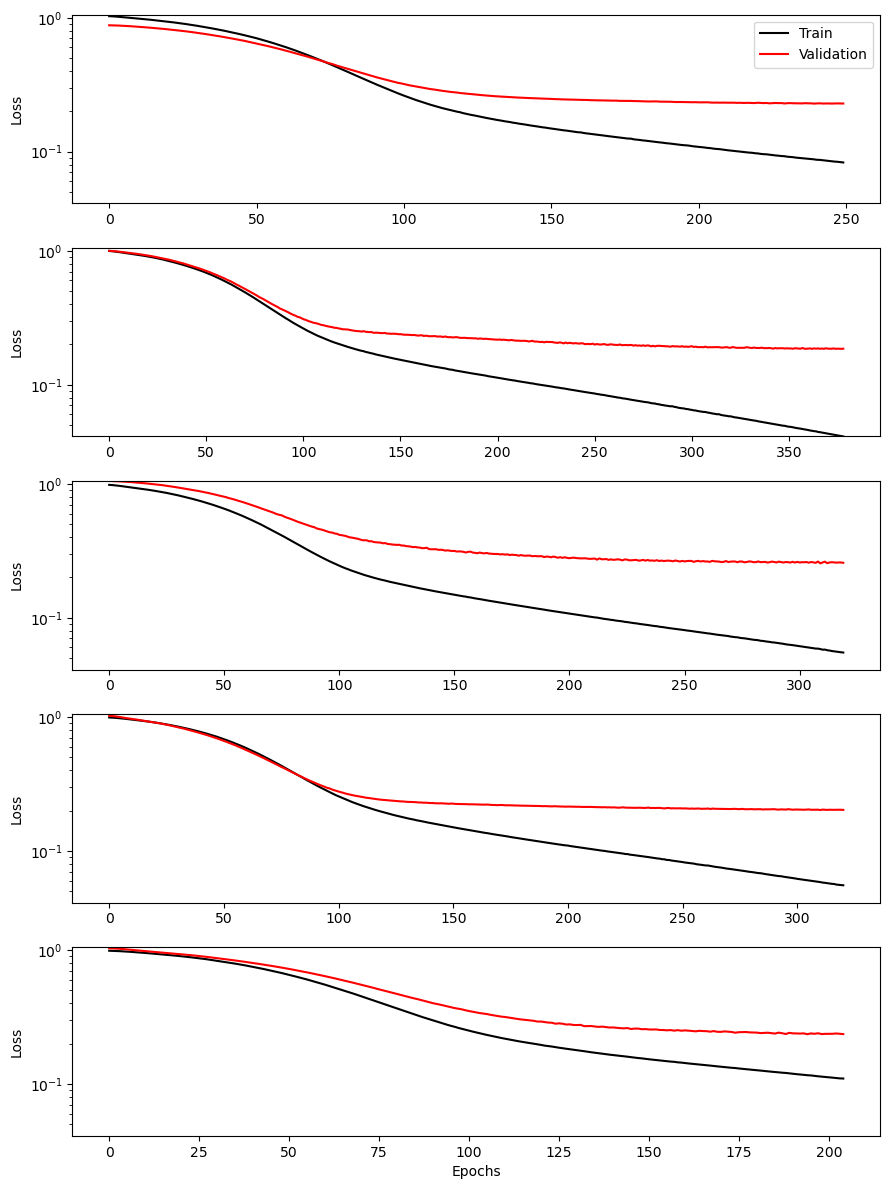

In [10]:

skills = [trained_model[1] for trained_model in trained_models[0:num_folds*NNrepeats]]
median_skill = np.median(skills)
median_index = skills.index(median_skill)
minimum_skill = np.min(skills)
min_index = skills.index(minimum_skill)
std_dev_skill = np.std(skills)

formatted_skills = [f"{skill:.4f}" for skill in skills]
logger.info(f"Losses in testing set: {formatted_skills}")
fold_median = median_index // NNrepeats + 1  # Compute fold number
ensemble_median = median_index % NNrepeats + 1  # Compute ensemble number
logger.info(f"Median Loss is: {median_skill:.4f}, which occurs at Fold {fold_median} Ensemble {ensemble_median}")
fold_min = min_index // NNrepeats + 1  # Compute fold number
ensemble_min = min_index % NNrepeats + 1  # Compute ensemble number
logger.info(f"Minimum Loss is: {minimum_skill:.4f}, which occurs at Fold {fold_min} Ensemble {ensemble_min}")
logger.info(f"Standard Deviation of the Loss is: {std_dev_skill:.4f}")
ratio = std_dev_skill/median_skill * 100
logger.info(f"Standard Deviation/Median: {ratio:.2f}%")

# Check if the standard deviation to median skill ratio is higher than 30%
if ratio > 30:
    warning_message = ("Warning: The standard deviation of model skill across "
                       "folds and ensembles is large!\nStandard Deviation/Median Skill: {ratio:.2f}%").format(ratio=ratio)
    with open(os.path.join(output_dir,'Warning_'+names_str+'.txt'), "w") as file:
        file.write(warning_message)
    with open(os.path.join(output_dir,'..','Warning_'+names_str+'.txt'), "w") as file:
        file.write(warning_message)


# Plot the loss function during training for all folds
# First, find the global minimum and maximum loss values across all folds
min_loss = min(min(trained_models[i][2]['loss']+trained_models[i][2]['val_loss']) for i in range(num_folds))
max_loss = max(max(trained_models[i][2]['loss']+trained_models[i][2]['val_loss']) for i in range(num_folds))

plt.figure(figsize=(9, 12))

# Plot the first fold outside the loop to avoid repeating the legend setting
plt.subplot(num_folds, 1, 1)
for nn in range(NNrepeats):
    plt.plot(trained_models[nn][2]['loss'],'-k')
    plt.plot(trained_models[nn][2]['val_loss'],'-r')
plt.ylabel('Loss')
plt.yscale('log')  # Set logarithmic scale
plt.ylim(min_loss, max_loss)  # Set the same y-limits for all subplots
plt.legend(['Train', 'Validation'], loc='upper right')

# Now plot the remaining folds
for n in range(1, num_folds):
    plt.subplot(num_folds, 1, n+1)
    for nn in range(NNrepeats):
        plt.plot(trained_models[n*NNrepeats+nn][2]['loss'],'-k')
        plt.plot(trained_models[n*NNrepeats+nn][2]['val_loss'],'-r')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set logarithmic scale
    plt.ylim(min_loss, max_loss)  # Set the same y-limits for all subplots

plt.xlabel('Epochs')
plt.subplots_adjust(hspace=0.5)  # Adjust space between plots if needed
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'TrainingLoss_' + names_str  + '.png'),dpi=300)
plt.show()


R2_each_fold_ens = [trained_models[i][4] for i in range(0,num_folds*NNrepeats)]

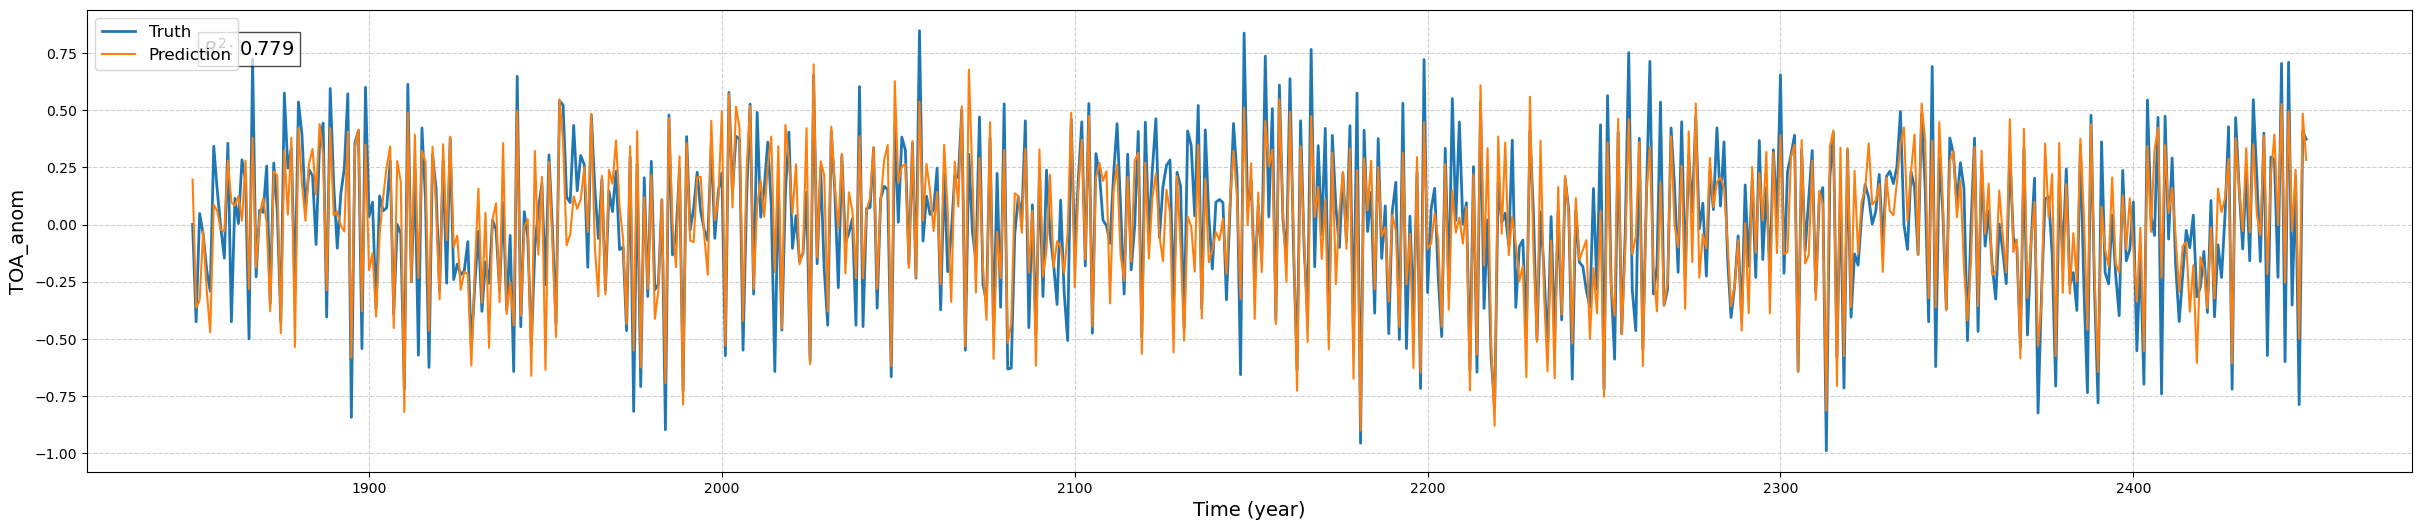

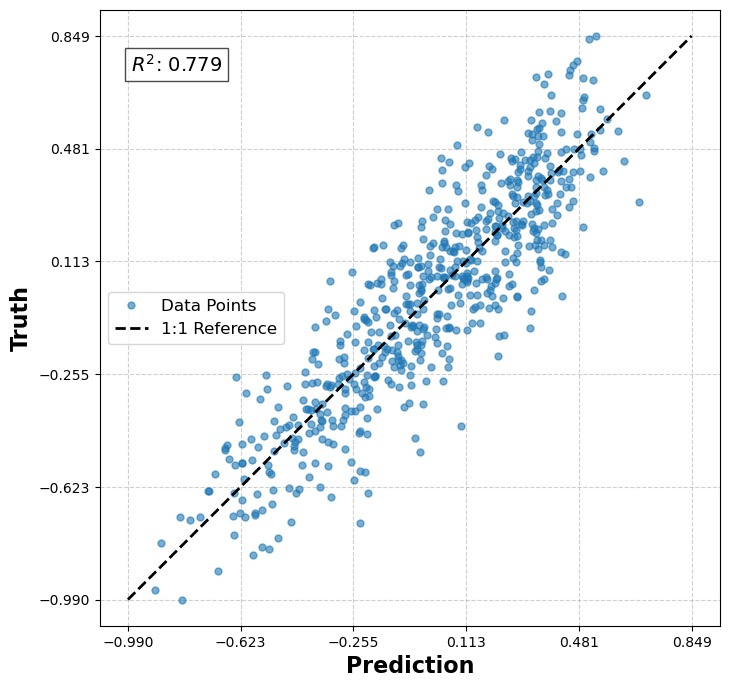

In [11]:

Model_preds = [np.concatenate([trained_models[n*NNrepeats + i][3] for n in range(num_folds)]) for i in range(NNrepeats)]
Model_pred = np.mean(Model_preds,axis=0)
Model_error = Model_pred - y



try:
    # Try to extract year numbers from cftime objects
    if hasattr(time, 'values') and hasattr(time.values[0], 'year'):
        time_numeric = np.array([t.year for t in time.values])
    elif hasattr(time[0], 'year'):
        time_numeric = np.array([t.year for t in time])
    else:
        time_numeric = np.arange(len(time))
except:
    # Fallback to simple numeric indexing
    time_numeric = np.arange(len(time))


plt.figure(figsize=(30, 6))  
plt.plot(time_numeric, y, label="Truth", color="C0", linewidth=2)  # Use color and linewidth
plt.plot(time_numeric, Model_pred, label="Prediction", color="C1", linestyle="-", linewidth=1.5)  # Dashed line for prediction
plt.xlabel("Time (year)", fontsize=14)
plt.ylabel(names_str, fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12, loc="best")
r2 = r2_score(y, Model_pred)
plt.text(0.05, 0.9, f"$R^2$: {r2:.3f}", transform=plt.gca().transAxes,
         fontsize=14, bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))
plt.savefig(os.path.join(output_dir, names_str+"_TruthvsPred.png"), dpi=300, bbox_inches="tight")
plt.show()


######### scatter plot

plt.figure(figsize=(8, 8))  # Keep square aspect ratio

# Scatter plot with adjusted marker size and transparency
plt.plot(Model_pred, y, 'o', markersize=5, alpha=0.6, color="C0", label="Data Points")

# Compute common limits based on both Model_pred and y
min_val = min(np.min(Model_pred), np.min(y))
max_val = max(np.max(Model_pred), np.max(y))

# Set same limits for x and y
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Define consistent tick locations
num_ticks = 6  # Adjust this for more or fewer ticks
ticks = np.linspace(min_val, max_val, num_ticks)

plt.xticks(ticks)
plt.yticks(ticks)

# 1:1 Reference Line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label="1:1 Reference")

# Labels and formatting
plt.xlabel("Prediction", fontsize=16, fontweight='bold')
plt.ylabel("Truth", fontsize=16, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.6)

# Compute and display R² score
r2 = r2_score(y, Model_pred)
plt.text(0.05, 0.9, f"$R^2$: {r2:.3f}", transform=plt.gca().transAxes,
         fontsize=14, bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))

# Equal aspect ratio for fair comparison
plt.axis("equal")

# Add legend (only for reference line)
plt.legend(fontsize=12, loc="center left")

# Save figure
plt.savefig(os.path.join(output_dir, "TOA_TruthvsPred_scatter.png"), dpi=300, bbox_inches="tight")

# Show plot
plt.show()